#### Load dataframe

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
import random
import torch
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import Compose, Lambda, Normalize

In [24]:
RANDOM_SEED = 42
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [25]:
calls_df = pd.read_csv('features_and_spectrograms.csv')
calls_df['log_padded_spectrogram'] = calls_df['log_padded_spectrogram'].apply(lambda x: np.array(json.loads(x)))

In [26]:
calls_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7283 entries, 0 to 7282
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   track_ID                7283 non-null   object 
 1   clip_ID                 7283 non-null   object 
 2   goose_ID                7283 non-null   object 
 3   call_type               7283 non-null   object 
 4   waveform                7283 non-null   object 
 5   sr                      7283 non-null   int64  
 6   filepath                7283 non-null   object 
 7   lfccs                   7283 non-null   object 
 8   peak                    7283 non-null   float64
 9   duration                7283 non-null   float64
 10  log_padded_spectrogram  7283 non-null   object 
 11  log_padded_lfccs        7283 non-null   object 
 12  f0mean                  6472 non-null   float64
 13  f0range                 6472 non-null   float64
 14  f0min                   6472 non-null   

In [27]:
print(len(calls_df[calls_df.isna().any(axis=1)]))
calls_df = calls_df.dropna()
calls_df = calls_df[["track_ID", "clip_ID", "goose_ID", "call_type", "log_padded_spectrogram"]]
calls_df.info()

811
<class 'pandas.core.frame.DataFrame'>
Index: 6472 entries, 0 to 7282
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   track_ID                6472 non-null   object
 1   clip_ID                 6472 non-null   object
 2   goose_ID                6472 non-null   object
 3   call_type               6472 non-null   object
 4   log_padded_spectrogram  6472 non-null   object
dtypes: object(5)
memory usage: 303.4+ KB


In [28]:
le = LabelEncoder()
le.fit(calls_df["call_type"])
calls_df["encoded_call_type"] = le.transform(calls_df["call_type"])

### Variational Autoencoder

In [29]:
LEARNING_RATE = 1e-3
BATCH_SIZE = 256 # very unbalanced dataset so choosing a bigger batch size - TODO balance
N_EPOCHS = 100
retrain = True

In [30]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


#### Create data loader

In [31]:
calls_df.iloc[0]["log_padded_spectrogram"].shape

(44, 170)

In [32]:
# data augmentation
spectrogram_transforms = Compose([
    Lambda(lambda spec: torch.roll(spec, shifts=random.randint(-60, 60), dims=-1)), # Random shift
    #Lambda(lambda spec: Normalize(spec)), 
])

In [33]:
class SoundDS(Dataset):
    # Custom data loader 
    def __init__(self, calls_df, transform=None):
        self.df = calls_df
        self.transform = transform
                
    # of items in dataset
    def __len__(self):
        return len(self.df)    
    
    # Get item through index
    def __getitem__(self, idx):
        spectrogram = torch.from_numpy(self.df.iloc[idx]["log_padded_spectrogram"]).to(torch.float32).to(device)
        spectrogram = spectrogram[np.newaxis, ...]
        if self.transform:
            spectrogram = spectrogram_transforms(spectrogram)
        return spectrogram, self.df.iloc[idx]["encoded_call_type"]

In [34]:
ds = SoundDS(calls_df, transform=True)

# Random split for train:val - 80:20
num_items = len(ds)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_ds, val_ds = random_split(ds, [num_train, num_val])

# Create training and validation data loaders
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

In [35]:
train_features, train_labels = next(iter(train_dl))
print(f"Feature batch shape: {train_features.size()}")

input_size=train_features.size()[1:]
print(input_size[1], input_size[2])

Feature batch shape: torch.Size([256, 1, 44, 170])
44 170


#### Define architecture

In [36]:
class ConvolutionalAutoencoder(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.encoder = torch.nn.Sequential(
            # input shape (n, 1, 44, 170)
            # TODO set one kernel to have higher frequency resolution, the other to have higher time resolution
            torch.nn.Conv2d(1, 8, (8,8), (2,2), (1,2)), # output shape (n, 8, 20, 84) 
            torch.nn.BatchNorm2d(8),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(8, 16, (4,4), (2,2), (1,1)), # output shape (n, 16, 10, 42)
            torch.nn.BatchNorm2d(16),
            torch.nn.LeakyReLU(),
            torch.nn.Flatten(), # output shape (n, 1280)
            torch.nn.Linear(6720, 4096),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(4096, 1024),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(1024, 256),
        )

        # latent mean and variance 
        self.mean_layer = torch.nn.Linear(256, 128)
        self.logvar_layer = torch.nn.Linear(256, 128)
        
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(128, 256),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(256, 1024),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(1024, 4096),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(4096, 6720),
            torch.nn.Unflatten(1, (16, 10, 42)),
            torch.nn.LeakyReLU(),
            torch.nn.BatchNorm2d(16),
            torch.nn.ConvTranspose2d(16, 8, (4,4), (2,2), (1,1)),
            torch.nn.LeakyReLU(),
            torch.nn.BatchNorm2d(8),
            torch.nn.ConvTranspose2d(8, 1, (8,8), (2,2), (1,2)),
            torch.nn.Sigmoid()
        )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def decode(self, x):
        return self.decoder(x)
    
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def forward(self, x):
        mean, log_var = self.encode(x)
        z = self.reparameterization(mean, log_var)
        x_hat = self.decode(z)
        return x_hat, mean, log_var

In [37]:
def loss_function(x, x_hat, mean, log_var, beta=1.0):
    # Reconstruction Loss (MSE)
    recon_loss = torch.nn.functional.mse_loss(x_hat, x, reduction='sum')  # Summed over all elements
    
    # KL Divergence Loss
    kl_divergence = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())
    
    return recon_loss + beta * kl_divergence

In [38]:
class EarlyStopper:
    # adapted from https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if np.abs(self.min_validation_loss - validation_loss) <= self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        else:
            self.counter = 0
        return False

In [39]:
def train(model, optimizer, train_dl, val_dl, epochs, device, early_stopper, beta):
    model.to(device)
    model.train()  # Set model to training mode
    
    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        # Training loop
        model.train()
        train_loss = 0
        for batch_idx, (x, _) in enumerate(train_dl):
            x = x.to(device)

            optimizer.zero_grad()  # Reset gradients
            
            # Forward pass
            x_hat, mean, log_var = model(x)
            
            # Compute loss
            loss = loss_function(x, x_hat, mean, log_var, beta)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        train_loss /= len(train_dl.dataset)  # Average loss over the entire dataset
        train_losses.append(train_loss)

        # Validation loop
        model.eval()  # Set model to evaluation mode
        val_loss = 0
        with torch.no_grad():  # Disable gradient calculation
            for batch_idx, (x, _) in enumerate(val_dl):
                x = x.to(device)  # Move data to device
                
                # Forward pass
                x_hat, mean, log_var = model(x)
                
                # Compute loss
                loss = loss_function(x, x_hat, mean, log_var, beta)
                val_loss += loss.item()
        
        val_loss /= len(val_dl.dataset)  # Average loss over the validation dataset
        val_losses.append(val_loss)
        # Print epoch statistics
        print(f"Epoch {epoch + 1}/{epochs} | Train Loss: {train_loss:.4f} | Validation Loss: {val_loss:.4f}")
        
        # Early stopping check
        if early_stopper.early_stop(val_loss):
            print(f"Early stopping triggered after {epoch + 1} epochs.")
            break
    
    return model, train_losses, val_losses

In [40]:
model = ConvolutionalAutoencoder()
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
early_stopper = EarlyStopper(patience=5, min_delta=1)

if retrain:
    trained_model, train_losses, val_losses = train(
            model=model,
            optimizer=optimizer,
            train_dl=train_dl,
            val_dl=val_dl,
            epochs=N_EPOCHS,
            device=device,
            early_stopper=early_stopper,
            beta=0.1
        )

ConvolutionalAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 8, kernel_size=(8, 8), stride=(2, 2), padding=(1, 2))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=6720, out_features=4096, bias=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Linear(in_features=4096, out_features=1024, bias=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Linear(in_features=1024, out_features=256, bias=True)
  )
  (mean_layer): Linear(in_features=256, out_features=128, bias=True)
  (logvar_layer): Linear(in_features=256, out_features=128, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)

In [41]:
if retrain:
    torch.save(trained_model.state_dict(), "/Users/lenagies/Desktop/Master/Thesis/geese/code/GooseVocalizations/trained_vae/convolutional_vae_weights.pth")
else:
    model.load_state_dict(torch.load("/Users/lenagies/Desktop/Master/Thesis/geese/code/GooseVocalizations/trained_vae/convolutional_vae_weights.pth", weights_only=True))

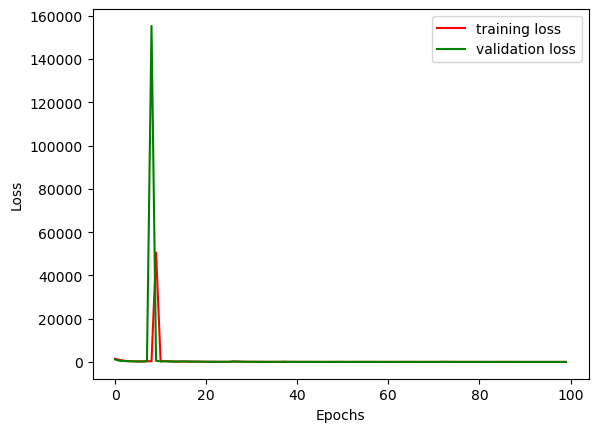

In [42]:
if retrain:
    plt.plot(train_losses, color='r', label='training loss')
    plt.plot(val_losses, color='g', label='validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')  
    plt.legend()
    plt.show()

Input device: mps:0, dtype: torch.float32
Model device: mps:0, dtype: torch.float32


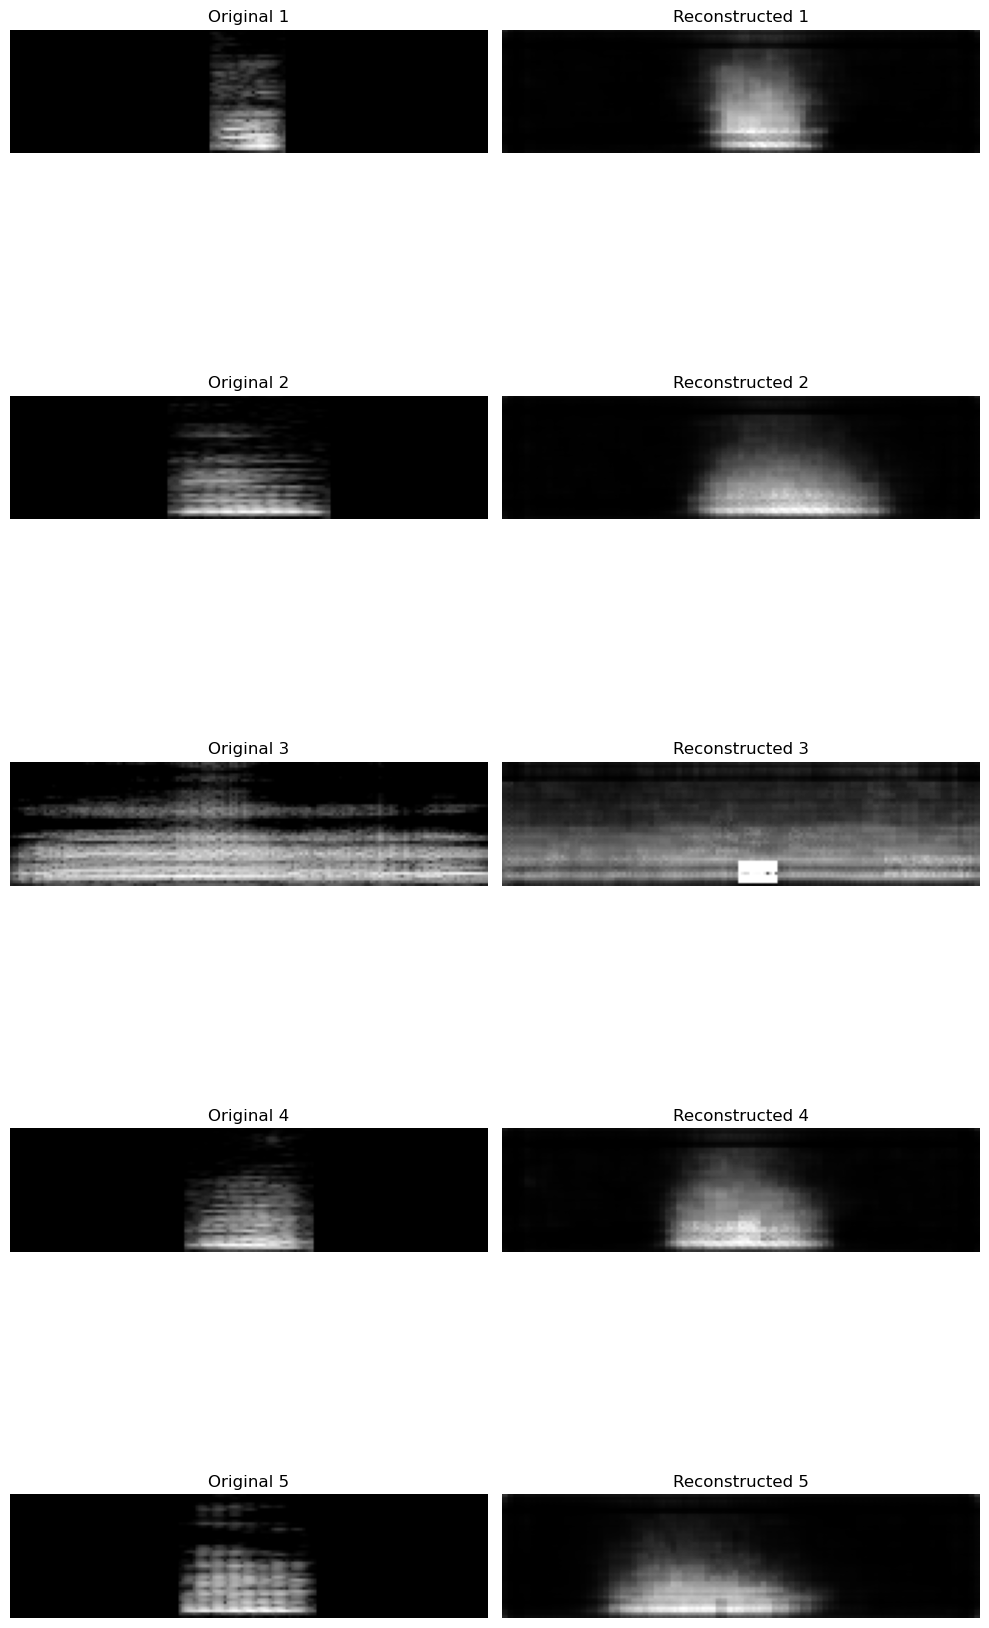

In [43]:
def plot_real_and_decoded_calls(train_dl, num_samples=5):
    # Get a batch of data from the DataLoader
    train_features, train_labels = next(iter(train_dl))
    
    # Ensure data is moved to the same device as the model
    train_features = train_features.to(device)
    train_labels = train_labels.to(device)
    
    # Print device information for debugging
    print(f"Input device: {train_features.device}, dtype: {train_features.dtype}")
    print(f"Model device: {next(model.parameters()).device}, dtype: {next(model.parameters()).dtype}")

    fig, axes = plt.subplots(num_samples, 2, figsize=(10, num_samples * 4))
    
    for i in range(num_samples):
        # Original call from dataset
        real_call = train_features[i].cpu().detach().numpy().reshape(44, 170)
        
        # Get latent representation of real call
        mean, log_var = model.encode(train_features[i].unsqueeze(0))  # Unsqueeze to add batch dimension
        z = model.reparameterization(mean, torch.exp(0.5 * log_var))
        
        # Decode latent vector to generate reconstructed call
        decoded_call = model.decode(z).detach().cpu().numpy().reshape(44, 170)
        
        # Plot original call
        axes[i, 0].imshow(real_call, origin='lower', cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"Original {i+1}")
        
        # Plot reconstructed call
        axes[i, 1].imshow(decoded_call, origin='lower', cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Reconstructed {i+1}")
    
    plt.tight_layout()
    plt.show()

ds = SoundDS(calls_df) # initialize again without transforms
full_dl = DataLoader(ds, batch_size=len(ds), shuffle=True)
plot_real_and_decoded_calls(full_dl, num_samples=5)


In [44]:
representations = []
with torch.no_grad():
    for batch_idx, (X, y) in enumerate(full_dl):
        X, y = X.to(device), y.to(device)
        mean, log_var = model.encode(X)
        z = model.reparameterization(mean, log_var)

        for i in range(len(y)):
            representations.append([y[i].item(), z[i].cpu().tolist()])

In [45]:
column_names = ["call_type", "latent_representation"]

In [46]:
representations_df = pd.DataFrame(representations, columns=column_names, index=None) 
representations_df.head()

,call_type,latent_representation
0,4,"[-0.0503467321395874, -0.23921430110931396, -0..."
1,4,"[-0.047396332025527954, -0.3198174834251404, -..."
2,4,"[-0.04891253262758255, -0.09013709425926208, -..."
3,2,"[-0.2972766160964966, -0.5203089714050293, -0...."
4,2,"[-0.40017515420913696, -0.33283644914627075, -..."
